# Question 6

"Train a (convolutional) neural network with the following dataset https://www.kaggle.com/harry418/dataset-for-mask-detection, which could be used for an automated mask-detection. Then capture your picture and/or your friends’ and family’s one (one person at a time so the algorithm does not get confused) with and/or without mask and see if the algorithm will classify the picture(s) correctly. Also report the accuracy of the method by following cross-validation methods."

In [1]:
import os, random
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.image import per_image_standardization as normalize

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Run this model on the GPU:
gpu_name = tf.test.gpu_device_name()

Notice that in the above code, we will be running on the GPU, so make sure to set the Runtime Type (under the "Runtime" tab at the top of this notebook) to "GPU" instead of "CPU" or "TPU".

In [ ]:
#%cd /content/drive/MyDrive/MATH_499_proj
#%cd Question_6

/content/drive/MyDrive/MATH_499_proj
/content/drive/MyDrive/MATH_499_proj/Question_6


First I'll create some functions to help us in preprocessing:

In [2]:
def generate_dataset_stats(path_to_imgs = "dataset"):

    x_sizes_m = []
    y_sizes_m = []
    z_sizes_m = []

    x_sizes_nm = []
    y_sizes_nm = []
    z_sizes_nm = []
    

    for f in os.listdir(path_to_imgs + "/with_mask"):
        img_path = path_to_imgs + "/with_mask" + "/" + f
        im = np.array(Image.open(img_path))
        #imResize = im.resize(Image.ANTIALIAS)

        x_sizes_m.append(im.shape[0])
        y_sizes_m.append(im.shape[1])
        z_sizes_m.append(im.shape[2])
    
    for f in os.listdir(path_to_imgs + "/without_mask"):
        img_path = path_to_imgs + "/without_mask" + "/" + f
        im = np.array(Image.open(img_path))

        x_sizes_nm.append(im.shape[0])
        y_sizes_nm.append(im.shape[1])
        z_sizes_nm.append(im.shape[2])

    print("Max X (mask):    ", max(x_sizes_m))
    print("Max X (no mask): ", max(x_sizes_nm))

    print("Min X (mask):    ", min(x_sizes_m))
    print("Min X (no mask): ", min(x_sizes_nm))

    print("")

    print("Max Y (mask):    ", max(y_sizes_m))
    print("Max Y (no mask): ", max(y_sizes_nm))

    print("Min Y (mask):    ", min(y_sizes_m))
    print("Min Y (no mask): ", min(y_sizes_nm))

    print("")

    print("Max Z (mask):    ", min(z_sizes_m))
    print("Max Z (no mask): ", min(z_sizes_nm))

    print("Min Z (mask):    ", min(z_sizes_m))
    print("Min Z (no mask): ", min(z_sizes_nm))

    print("")

    print("Mean X (mask):    ", np.mean(x_sizes_m))
    print("Mean X (no mask): ", np.mean(x_sizes_nm))

    print("Mean Y (mask):    ", np.mean(y_sizes_m))
    print("Mean Y (no mask): ", np.mean(y_sizes_nm))

    print("Mean Z (mask):    ", np.mean(z_sizes_m))
    print("Mean Z (no mask): ", np.mean(z_sizes_nm))

    print("")
    print("Total # of samples = ", len(x_sizes_m) + len(x_sizes_nm))

def generate_dataset(path_to_imgs = "dataset", plot_random = False, resize_shape = (300, 300)):

    X = []
    y = []

    for f in os.listdir(path_to_imgs + "/with_mask"):
        img_path = path_to_imgs + "/with_mask" + "/" + f
        im = Image.open(img_path)
        imResize = im.resize(resize_shape, Image.ANTIALIAS)

        X.append(np.array(imResize))

        y.append(1)
    
    for f in os.listdir(path_to_imgs + "/without_mask"):
        img_path = path_to_imgs + "/without_mask" + "/" + f
        im = Image.open(img_path)

        imResize = im.resize(resize_shape, Image.ANTIALIAS)

        X.append(np.array(imResize))

        y.append(0)

    # Convert to numpy
    X = np.array(X)
    y = np.array(y)

    if (plot_random):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle("Randomly Chosen Images (Regular)")
        ax1.imshow(X[random.choice(np.argwhere(y == 1))][0])
        ax1.set_title("Mask")
        ax2.imshow(X[random.choice(np.argwhere(y == 0))][0])
        ax2.set_title("No Mask")
        plt.show()

    # Normalize and show X:
    X = np.array([normalize(np.array(x)).numpy() for x in X]) 

    if (plot_random):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle("Randomly Chosen Images (Normalized)")
        ax1.imshow(X[random.choice(np.argwhere(y == 1))][0])
        ax1.set_title("Mask")
        ax2.imshow(X[random.choice(np.argwhere(y == 0))][0])
        ax2.set_title("No Mask")
        plt.show()

    return X, y

## Dataset Statistics
First we'll view the statistics of the images in our dataset:

In [3]:
generate_dataset_stats()

Max X (mask):     1500
Max X (no mask):  960
Min X (mask):     134
Min X (no mask):  132

Max Y (mask):     1500
Max Y (no mask):  960
Min Y (mask):     134
Min Y (no mask):  110

Max Z (mask):     3
Max Z (no mask):  3
Min Z (mask):     3
Min Z (no mask):  3

Mean X (mask):     206.34726224783861
Mean X (no mask):  340.16574585635357
Mean Y (mask):     262.6902017291066
Mean Y (no mask):  299.9134438305709
Mean Z (mask):     3.0
Mean Z (no mask):  3.0

Total # of samples =  1237


We can see that we have different sizes of images throughout the data, so we need to resize each of the images. I chose to resize them to (300, 300, 3) because square images work easier with CNN's. Also, we expect to see 3 for all Z values because these are RBG images (i.e. one channel for R, B, and G). 

The below code will process the dataset we'll feed into the CNN.

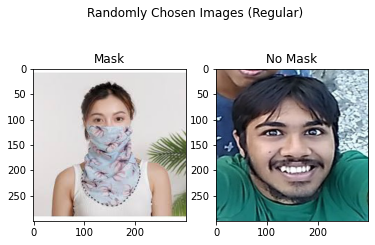

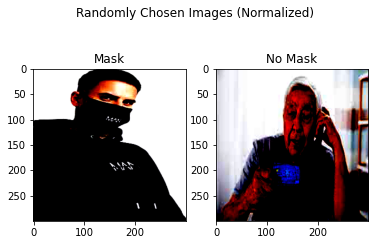

In [4]:
X, y = generate_dataset(plot_random = True, resize_shape = (300, 300))

Now we can visualize the classes in the dataset:

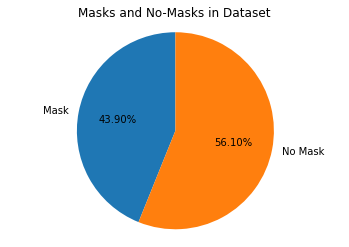

In [5]:
# Visualize the classes in the data:
fig, ax = plt.subplots()
ly = list(y)
sizes = [ly.count(i) for i in range(0,2)]
ax.pie(sizes, labels = ["Mask", "No Mask"], autopct ="%1.2f%%", startangle = 90)
ax.axis('equal')
plt.title("Masks and No-Masks in Dataset")
plt.show()

This dataset is not balanced; however, CNN's perform better when the dataset does have balance, so we will weight the samples in the training procedure.

## Convolutional Neural Net Architecture
Now we need to create our Convolutional Neural Network (CNN). I will use Tensorflow's Keras library to do this because I think it has one of the easiest API's out there.

The CNN that I have built utilizes several types of layers:

1. **Convolutional Layer**
  - This layer performs convolutions over the training images, extracting information into the kernel for each node in the layer. 

![Convolutions](https://miro.medium.com/max/1000/1*GcI7G-JLAQiEoCON7xFbhg.gif)

Source: TowardsDataScience.com

As one can see in this GIF, the kernel, or the yellow box on the left, slides over the image, computing dot products at each step. In contrast to a traditional neural network, this kernel is shared across the entire image, with the same weights computing dot products at each point in the image.

The idea of a convolution comes from signal processing, and it is practically implemented by utilizing a shift matrix, one that, upon multiplication, moves the kernel across the image with each step. Through this process, the kernel extracts high-level feature data from the image, extracting patterns that regular neural networks would be unable to detect.

2. **Batch Normalization**
  - This standardizes the inputs to the following layer, which helps improve performance and reduce the propagation of unwanted errors from one layer to the other layers in the network.

3. **Dropout**
  - This layer randomly drops some outputs from nodes in the previous layer. This has the effect of making the training process noisy, forcing the layers of the network to be less sensitive to noise in the training data. 

4. **Max Pooling**
  - Pooling layers reduce the dimensionality of the input images, improving the speed and memory use of the network in both training and testing. 

5. **Dense Layers**
  - Convolutional layers are actually just feature extraction tools in our network - they cannot make predictions by themselves. To classify our images, we need a fully-connected neural network at the end. 
  - This fully-connected net is made up of what Tensorflow calls "dense" layers - fully-connected layers of nodes. This completes the network and makes it a robust, end-to-end classifier.

In [6]:
def CNN(input_shape):
  model = keras.models.Sequential()

  # Convolutional layers:
  model.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', input_shape = input_shape))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.MaxPooling2D())

  model.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.MaxPooling2D())

  model.add(keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.MaxPooling2D())

  # Flatten before fully-connected network:
  model.add(keras.layers.Flatten())

  # Fully-connected network:
  model.add(keras.layers.Dense(64, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'))
  model.add(keras.layers.Dense(32, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'))
  model.add(keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer='random_normal', bias_initializer='zeros'))
  return model

It's important to note here that the last layer acts as an activation layer, using the sigmoid activation function to bring the output from the previous layers to a value between 0 and 1. If the output is above 0.5, the sample is classified as 1, otherwise, it is classified as 0.

Now we can visualize the model using Keras's summary function:

In [7]:
blank_model = CNN(X[0].shape)
blank_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 300, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 300, 300, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 128)     7

I define the training function below, where I make a few hyperparameter choices:

1. Optimizer: Stochastic Gradient Descent (SGD)
  - This is the function that will update the weights in our network, using the gradient calculated by the backpropagation algorithm. 
  - SGD works just like gradient descent, discussed in Question 5 of this project, but instead of updating network weights with every training sample, the model is trained in batches, and a random sample from the batch is selected to serve as the basis for updating the weights after training that batch. 

2. Loss function: Binary Cross Entropy
  - This function determines how we penalize the network when it makes wrong decisions. Cross entropy is a popular loss function used in classification tasks because it takes into account not only the inaccuracy of a prediction but the network's confidence in that inaccurate prediction (higher output probability).

3. Class weights
  - Here I choose to weight each of the classes inversely proportional to their prevalence in the training data. CNN's work better with a balanced training dataset, so introducing weights to counteract the imbalance in the dataset will achieve better results in the final training procedure.

In [8]:
def train(Xtrain, Ytrain, model, epochs = 10, verbose_level = 1):

  metrics = ['accuracy', keras.metrics.Precision(name = 'precision'), \
                        keras.metrics.Recall(name = 'recall')]

  sgd = keras.optimizers.SGD(lr = 0.001)

  model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = metrics)

  cweight_arr = compute_class_weight('balanced', np.unique(Ytrain), Ytrain)
  cweight = {0: cweight_arr[0], 1: cweight_arr[1]}
  history = model.fit(Xtrain, Ytrain, batch_size = 30, 
                      epochs = epochs, shuffle = True, 
                      class_weight = cweight, verbose = verbose_level)
  
  return model

## Cross Validation

Now we will peform 5-fold cross validation on our model with the entire dataset in order to test the validity of our model. I chose to train the model for 40 epochs (full passes through the dataset) because this showed to be an adequate amount during the testing phases of my development.

In [ ]:
kf = KFold(n_splits = 5, shuffle = True)
cval_iter = kf.split(X, y)

i = 0

with tf.device(gpu_name):
  for ctrain, test in cval_iter:
    model = CNN(X[0].shape)
    train(X[ctrain], y[ctrain], model = model, epochs = 40, verbose_level = 0)

    # Obtain predictions
    preds = model.predict(X[test])
    predictions = [0 if pred < 0.5 else 1 for pred in preds]

    print("CV Accuracy Report, Split {}".format(i))
    print(classification_report(y[test], predictions))
    print("")
    i += 1


CV Accuracy Report, Split 0
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       116
           1       0.82      0.66      0.73       132

    accuracy                           0.74       248
   macro avg       0.75      0.75      0.74       248
weighted avg       0.76      0.74      0.74       248


CV Accuracy Report, Split 1
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       113
           1       0.80      0.81      0.81       135

    accuracy                           0.79       248
   macro avg       0.79      0.79      0.79       248
weighted avg       0.79      0.79      0.79       248


CV Accuracy Report, Split 2
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       114
           1       0.82      0.74      0.77       133

    accuracy                           0.77       247
   macro avg       0.77      0.77      0.7

Before we try to predict whether my selfies are wearing masks or not, we will train a model on the entire dataset for better representation. This way, my selfies will be used as a "testing set" for the model:

In [10]:
with tf.device(gpu_name):
    net = CNN(X[0].shape)
    train(X, y, net, epochs = 40)

Epoch 1/40
30/42 [====================>.........] - ETA: 3:11 - loss: 0.8394 - accuracy: 0.5544 - precision: 0.6065 - recall: 0.5314

KeyboardInterrupt: 

## Classifying My Own Picture
You can see two selfies of me below: one with a mask and one without a mask. We will see how the model performs on this data: 

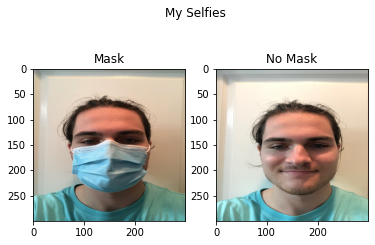

In [ ]:
# Load in the images:
img_path1 = "mask_selfie.jpeg"
im1 = Image.open(img_path1)
imResize1 = im1.resize((300, 300), Image.ANTIALIAS)

mask_selfie = np.array(imResize1)

img_path2 = "nomask_selfie.jpeg"
im2 = Image.open(img_path2)
imResize2 = im2.resize((300, 300), Image.ANTIALIAS)

nomask_selfie = np.array(imResize2)

# Showing the images:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("My Selfies")
ax1.imshow(mask_selfie)
ax1.set_title("Mask")
ax2.imshow(nomask_selfie)
ax2.set_title("No Mask")
plt.show()

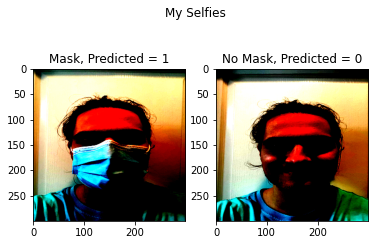

In [ ]:
# Now normalize and test the samples
mask_selfie = normalize(np.array(mask_selfie)).numpy()
nomask_selfie = normalize(np.array(nomask_selfie)).numpy()

testing_Xset = np.array([mask_selfie, nomask_selfie])
testing_Yset = np.array([1, 0])

selfie_preds = [0 if pred < 0.5 else 1 for pred in net.predict(testing_Xset)]

# Showing the images with predicted labels:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("My Selfies")
ax1.imshow(mask_selfie)
ax1.set_title("Mask, Predicted = {}".format(selfie_preds[0]))
ax2.imshow(nomask_selfie)
ax2.set_title("No Mask, Predicted = {}".format(selfie_preds[1]))
plt.show()